In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import skimage.exposure
import os

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
train=pd.read_csv("/content/drive/MyDrive/mammography_images/Testing_set.csv")
test=pd.read_csv("/content/drive/MyDrive/mammography_images/Training_set.csv")
sub=pd.read_csv("/content/drive/MyDrive/mammography_images/sample_submission.csv")

In [ ]:
%cd /content/drive/MyDrive/mammography_images/train

/content/drive/MyDrive/mammography_images/train


In [ ]:

train.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:

print("len of training set", len(train))
print("len of testing set", len(test))

len of training set 200
len of testing set 600


In [ ]:
# Load the data from the CSV files
train = pd.read_csv("/content/drive/MyDrive/mammography_images/Training_set.csv")
test = pd.read_csv("/content/drive/MyDrive/mammography_images/Testing_set.csv")
sub = pd.read_csv("/content/drive/MyDrive/mammography_images/sample_submission.csv")

# Check if the 'train' variable has a column named 'label'
if 'label' not in train.columns:
    raise ValueError("The 'train' variable does not have a column named 'label'")

# Print the number of rows in the training and testing sets
print("Number of rows in the training set:", len(train))
print("Number of rows in the testing set:", len(test))

# Print the value counts of the 'label' column in the training set
print(train["label"].value_counts())

Number of rows in the training set: 600
Number of rows in the testing set: 200
label
Density2Malignant    189
Density1Malignant    181
Density3Benign        64
Density1Benign        58
Density3Malignant     46
Density4Benign        42
Density2Benign        13
Density4Malignant      7
Name: count, dtype: int64


In [ ]:
print(train.columns)


Index(['filename', 'label'], dtype='object')


In [ ]:
print(train.head())


      filename              label
0  Image_1.jpg     Density3Benign
1  Image_2.jpg     Density1Benign
2  Image_3.jpg  Density1Malignant
3  Image_4.jpg     Density1Benign
4  Image_5.jpg  Density1Malignant


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Density3Benign'),
  Text(1, 0, 'Density1Benign'),
  Text(2, 0, 'Density1Malignant'),
  Text(3, 0, 'Density4Benign'),
  Text(4, 0, 'Density2Malignant'),
  Text(5, 0, 'Density3Malignant'),
  Text(6, 0, 'Density2Benign'),
  Text(7, 0, 'Density4Malignant')])

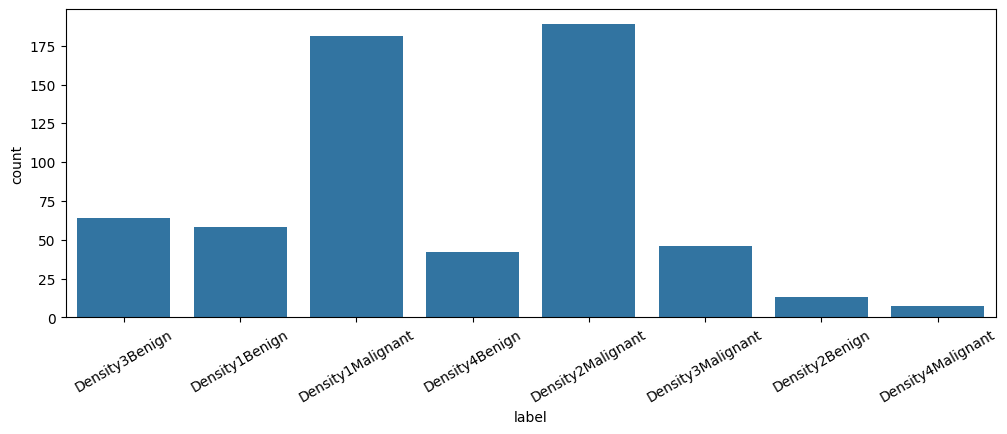

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x=train["label"],data=train,)
plt.xticks(rotation=30)

In [ ]:
train[train["label"]=="Density3Benign"]

,filename,label
0,Image_1.jpg,Density3Benign
6,Image_7.jpg,Density3Benign
19,Image_20.jpg,Density3Benign
24,Image_25.jpg,Density3Benign
33,Image_34.jpg,Density3Benign
...,...,...
547,Image_548.jpg,Density3Benign
552,Image_553.jpg,Density3Benign
568,Image_569.jpg,Density3Benign
569,Image_570.jpg,Density3Benign


In [ ]:

def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

In [ ]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [ ]:
print("len of training set", len(X_train))
print("len of validation set", len(X_valid))

len of training set 540
len of validation set 60


In [ ]:
datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=X_train,
directory="/content/drive/MyDrive/mammography_images/test",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 177 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 363 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


(224, 224, 3)
(224, 224, 3)


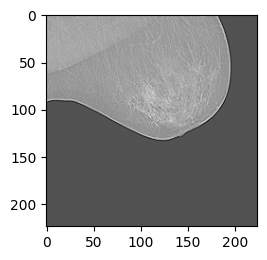

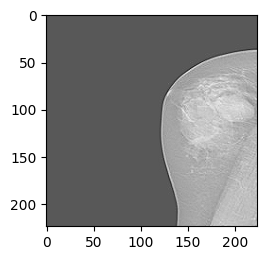

In [ ]:
x,y = train_generator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)

plt.show()

In [ ]:
valid_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
valid_generator=valid_datagen.flow_from_dataframe(
dataframe=X_valid,
directory="/content/drive/MyDrive/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 60 validated image filenames belonging to 8 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
checkpoint_path = "training_0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
               EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
def build_model():
  model = Sequential()

  conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(8, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

In [ ]:

my_model=build_model()

In [ ]:
my_model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.00001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))


In [ ]:
my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=5,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 786.4220 - accuracy: 0.1379
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to training_0/cp.ckpt
5/5 [==============================] - 60s 10s/step - loss: 786.4220 - accuracy: 0.1379 - val_loss: 787.0005 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 784.1160 - accuracy: 0.2621
Epoch 2: val_accuracy improved from 0.00000 to 0.09375, saving model to training_0/cp.ckpt
5/5 [==============================] - 7s 2s/step - loss: 784.1160 - accuracy: 0.2621 - val_loss: 784.9127 - val_accuracy: 0.0938 - lr: 1.0000e-05
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 781.8221 - accuracy: 0.4345
Epoch 3: val_accuracy did not improve from 0.09375
5/5 [==============================] - 3s 540ms/step - loss: 781.8221 - accuracy: 0.4345 - val_loss: 782.3565 - val_accuracy: 0.0625 - lr: 1.0000e-05
Epoch 4/5
5/5 [==========================

In [ ]:
my_model.load_weights(checkpoint_path)

In [ ]:
my_model.evaluate(valid_generator,verbose=1)

2/2 [==============================] - 1s 144ms/step - loss: 784.4980 - accuracy: 0.1000


[784.498046875, 0.10000000149011612]

In [ ]:
train_generator.class_indices

{'Density1Benign': 0,
 'Density1Malignant': 1,
 'Density2Benign': 2,
 'Density2Malignant': 3,
 'Density3Benign': 4,
 'Density3Malignant': 5,
 'Density4Benign': 6,
 'Density4Malignant': 7}

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/drive/MyDrive/mammography_images/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 200 validated image filenames.


In [ ]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

200/200 [==============================] - 9s 30ms/step


In [ ]:

pred1


array([7, 7, 7, 5, 3, 7, 7, 3, 3, 7, 3, 7, 3, 7, 7, 7, 7, 7, 7, 3, 7, 7,
       3, 7, 7, 3, 7, 7, 3, 7, 7, 3, 3, 3, 7, 7, 7, 7, 3, 3, 3, 3, 7, 7,
       7, 3, 7, 3, 7, 7, 3, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 7, 7, 7,
       3, 7, 3, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 7, 3, 3, 7, 7, 7,
       3, 7, 3, 7, 7, 7, 7, 7, 5, 7, 3, 3, 7, 3, 7, 7, 7, 3, 7, 3, 7, 3,
       7, 7, 7, 3, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 3, 7, 3, 7, 7, 7,
       7, 3, 7, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 3, 7,
       3, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       5, 3, 7, 3, 7, 7, 3, 7, 7, 7, 7, 7, 3, 7, 3, 7, 7, 7, 7, 3, 3, 3,
       3, 7])

In [ ]:
sub["label"]=pred1
sub["label"]=sub["label"].map({0:'Density1Benign',
 1:'Density1Malignant',
 2:'Density2Benign',
 3:'Density2Malignant',
 4: 'Density3Benign',
 5: 'Density3Malignant',
 6:'Density4Benign',
 7:  'Density4Malignant'})

In [ ]:
sub["label"].value_counts()

label
Density4Malignant    139
Density2Malignant     57
Density3Malignant      4
Name: count, dtype: int64

In [ ]:

sub.to_csv("9.csv",index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import datasets

# Loading a dataset (for example, the Iris dataset)
iris = datasets.load_breast_cancer() # Load the breast cancer dataset
X = iris.data
y = iris.target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating the decision tree classifier
clf = DecisionTreeClassifier()

# Training the classifier
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Evaluating the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(matrix)


Accuracy: 0.9298245614035088
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        63
           1       0.97      0.92      0.94       108

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Confusion Matrix:
[[60  3]
 [ 9 99]]


In [ ]:
import pickle

# Assuming 'clf' is your trained decision tree classifier
with open('classifier.pkl','wb') as file:
    pickle.dump(clf, file) # Save the classifier 'clf'